This is the banchmarking of the network architecture 

In [1]:
import sys
sys.path.append('../../..')

import os
os.environ['PYTHONPATH'] = '../../..'

In [ ]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MEDfl Imports 
## Network Manager Imports 
from MEDfl.NetManager.node import Node
from MEDfl.NetManager.network import Network
from MEDfl.NetManager.dataset import DataSet
from MEDfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from MEDfl.LearningManager.dynamicModal import DynamicModel
from MEDfl.LearningManager.model import Model
from MEDfl.LearningManager.strategy import Strategy
from MEDfl.LearningManager.server import *
from MEDfl.LearningManager.flpipeline import *
from MEDfl.LearningManager.plot import AccuracyLossPlotter


200
# Utils
from MEDfl.LearningManager.utils import *


In [3]:
# DB Creation 
!python ../../../scripts/create_db.py

# clearn DB 
# empty_db()

d:\ESI\3CS\PFE\last_year\Code\MEDfl\scripts\create_db.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network")
Net_1.create_network()

Net_1.name

'manual_network'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


1

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_1", description = "The first fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

FLsetupId       name         description       creation_date  NetId  \
0          1  Flsetup_1  The first fl setup 2024-03-13 13:20:29      1   

  column_name  
0        None

# Configuration_1: A Manual network with 5 Nodes 
This network contains 5 nodes (3 Train nodes and 2 test nodes)

In [7]:
# Create 5 nodes 
hospital_1,hospital_2,hospital_3, hospital_4 , hospital_5 = Node(name = "hospital_1", train = 1),Node(name = "hospital_2", train = 1),Node(name = "hospital_3", train = 1),Node(name = "hospital_4", train = 0),Node(name = "hospital_5", train = 0)

In [8]:
# Assign the 3 nodes to the man_network 
Net_1.add_node(hospital_1)
Net_1.add_node(hospital_2)
Net_1.add_node(hospital_3) 
Net_1.add_node(hospital_4)
Net_1.add_node(hospital_5) 

In [9]:
# List all created nodes on the db 
Node.list_allnodes()

NodeId    NodeName  train  NetId
0       1  hospital_1      1      1
1       2  hospital_2      1      1
2       3  hospital_3      1      1
3       4  hospital_4      0      1
4       5  hospital_5      0      1

In [10]:
# Define the path of the files 
# Train Data 
Ds_1 = global_params['base_url']+ '/notebooks/data/config_1/part_1.csv'
Ds_2 = global_params['base_url']+ '/notebooks/data/config_1/part_2.csv'
Ds_3 = global_params['base_url']+ '/notebooks/data/config_1/part_3.csv'

# pload the DataSets 
hospital_1.upload_dataset( dataset_name = "hospital_1_dataset" , path_to_csv=Ds_1  )
hospital_2.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=Ds_2)
hospital_3.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=Ds_3 )

# Test Data 
test_1 = global_params['base_url']+ '/notebooks/data/config_1/test_1.csv'
test_2 = global_params['base_url']+ '/notebooks/data/config_1/test_2.csv'

hospital_4.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=test_1)
hospital_5.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=test_2 )




In [11]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [12]:
fl_dataset.size

17

In [13]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.00452527,  0.23571293,  0.09641246, -0.09073075,  0.169308  ,
          0.19799607,  0.04264654, -0.13273463,  0.17993627,  0.02797261,
         -0.03094019, -0.21617025,  0.13514723,  0.06685891,  0.0406791 ,
         -0.01893167,  0.07132187]], dtype=float32),
 array([-0.0984169], dtype=float32)]

In [14]:
# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [15]:
# Load the pretrained model
model = Model.load_model("../../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")


# Pass the specific_model to the Model class
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(model, optimizer, criterion)

# Get the initial params of the model 
init_params = global_model.get_parameters() ; 

print(global_model.optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [19]:
import importlib

from MEDfl.LearningManager import strategy
importlib.reload(strategy)

from MEDfl.LearningManager.strategy import Strategy

from MEDfl.LearningManager import server
importlib.reload(server)

from MEDfl.LearningManager.server import FlowerServer

from MEDfl.LearningManager import flpipeline
importlib.reload(flpipeline)

from MEDfl.LearningManager.flpipeline import FLpipeline

from MEDfl.LearningManager import client
importlib.reload(client)

from MEDfl.LearningManager import params_optimiser
importlib.reload(params_optimiser)

from MEDfl.LearningManager.params_optimiser import ParamsOptimiser 



In [27]:
params = {
    'learning_rate': {'low': 1e-5, 'high': 1e-1, 'log': True},
    'n_trials' : 100 , 
    'optimizer': ['Adam', 'SGD', 'RMSprop'], 
    'num_rounds' : {'low' : 5 , 'high': 15},
    'fl_strategy' : ["FedAdam" , "FedAvg" , "FedAdagrad" ,"FedYogi"],
    'diff_privacy' : [1,0]
}

In [28]:
optimizer = ParamsOptimiser()

optimizer.federated_params_iptim(params=params , 
                                 direction="maximize" , 
                                 model=model , 
                                 fl_dataset=fl_dataset)

[I 2024-03-13 17:41:31,536] A new study created in memory with name: no-name-ac40f978-eb9f-4c0c-9b85-8c384055bbaa
INFO flwr 2024-03-13 17:41:31,542 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
03/13/2024 17:41:31:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
2024-03-13 17:41:35,206	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:41:37,564 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'CPU': 24.0, 'memory': 33843100877.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
03/13/2024 17:41:37:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'CPU': 24.0, 'memory': 33843100877.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-03-13 17:41:37,565 | app.py:219 | Optimize your simula

(DefaultActor pid=549260) 
(DefaultActor pid=549260)  -------------------------------- 
(DefaultActor pid=549260)   this is the config of the client
(DefaultActor pid=549260) [Client 0] fit, config: {}
(DefaultActor pid=549260) 
(DefaultActor pid=549260)  -------------------------------- 
(DefaultActor pid=549260)   
(DefaultActor pid=549260) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.187500
(DefaultActor pid=549260) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.906250
(DefaultActor pid=549260) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.541667
(DefaultActor pid=549260) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.578125
(DefaultActor pid=549260) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.187500
(DefaultActor pid=549260) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.906250
(DefaultActor pid=549260) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=549260) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.390625
(DefaultActor pid=549260) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 82.187500
(Defau

(DefaultActor pid=549260) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=549260)   warnings.warn(
(DefaultActor pid=549260) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=549260)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:41:48,836 | server.py:236 | fit

(DefaultActor pid=549260) epsilon of client 0 : eps = 0
(DefaultActor pid=549260) [Client 2] evaluate, config: {}
(DefaultActor pid=549259)    [repeated 15x across cluster]
(DefaultActor pid=549259)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=549259)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=549259) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=549260) 	Train Epoch: 57 	Loss: 0.693147 Acc@1: 80.468750 [repeated 2036x across cluster]


DEBUG flwr 2024-03-13 17:41:52,308 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:41:52:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:41:52,320 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.66969277500175)
03/13/2024 17:41:52:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.66969277500175)
DEBUG flwr 2024-03-13 17:41:52,321 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:41:52:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:41:52,351 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=549259) epsilon of client 1 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=549259) [Client 0] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:41:55,678 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:41:55:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:41:55,709 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.057720641954802)
03/13/2024 17:41:55:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.057720641954802)
DEBUG flwr 2024-03-13 17:41:55,711 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:41:55:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:41:55,743 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=549259)    [repeated 9x across cluster]
(DefaultActor pid=549259)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=549259)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=549259) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=549260) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 81.328125 [repeated 2091x across cluster]


DEBUG flwr 2024-03-13 17:41:59,128 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:41:59:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:41:59,140 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.48956084495876)
03/13/2024 17:41:59:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.48956084495876)
DEBUG flwr 2024-03-13 17:41:59,141 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:41:59:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=549262) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=549259) [Client 1] evaluate, config: {} [repeated 3x across cluster]


ERROR flwr 2024-03-13 17:41:59,168 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=549259)    [repeated 18x across cluster]
(DefaultActor pid=549259)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=549259)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=549259) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=549260) 	Train Epoch: 52 	Loss: 0.693147 Acc@1: 83.125000 [repeated 2012x across cluster]


DEBUG flwr 2024-03-13 17:42:02,621 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:42:02:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:02,642 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 24.990898816962726)
03/13/2024 17:42:02:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 24.990898816962726)
DEBUG flwr 2024-03-13 17:42:02,643 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:02:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:02,667 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=549262) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=549259) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=549259)    [repeated 9x across cluster]
(DefaultActor pid=549259)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=549259)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=549259) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=549260) 	Train Epoch: 106 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2045x across cluster]


DEBUG flwr 2024-03-13 17:42:06,096 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:42:06:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:06,107 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.456533303949982)
03/13/2024 17:42:06:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.456533303949982)
DEBUG flwr 2024-03-13 17:42:06,108 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:06:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:06,134 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=549259) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=549259) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:42:09,472 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:42:09:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:09,500 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 31.849126659915783)
03/13/2024 17:42:09:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 31.849126659915783)
DEBUG flwr 2024-03-13 17:42:09,502 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:09:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:09,542 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=549259)    [repeated 18x across cluster]
(DefaultActor pid=549259)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=549259)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=549259) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=549260) 	Train Epoch: 40 	Loss: 0.693147 Acc@1: 83.541667 [repeated 2005x across cluster]


DEBUG flwr 2024-03-13 17:42:12,933 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:42:12:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:12,946 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.29477209690958)
03/13/2024 17:42:12:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.29477209690958)
DEBUG flwr 2024-03-13 17:42:12,947 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:12:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:12,970 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=549262) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=549259) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=549259) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.656250 [repeated 926x across cluster]


2024-03-13 17:42:16,748	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:42:19,146 | app.py:213 | Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 1.0, 'memory': 34491169997.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'node:__internal_head__': 1.0, 'CPU': 24.0}
03/13/2024 17:42:19:INFO:Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 1.0, 'memory': 34491169997.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'node:__internal_head__': 1.0, 'CPU': 24.0}
INFO flwr 2024-03-13 17:42:19,146 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:42:19:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:42:19,147 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=550820) 
(DefaultActor pid=550820)  -------------------------------- 
(DefaultActor pid=550820)   this is the config of the client
(DefaultActor pid=550820) [Client 1] fit, config: {}
(DefaultActor pid=550820) 
(DefaultActor pid=550820)  -------------------------------- 
(DefaultActor pid=550820)   
(DefaultActor pid=550820) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=550820) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=550820) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=550820) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=550820) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=550820) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 78.906250
(DefaultActor pid=550820) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 79.791667
(DefaultActor pid=550820) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.234375


(DefaultActor pid=550821) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=550821)   warnings.warn(
(DefaultActor pid=550821) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=550821)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:42:29,811 | server.py:236 | fit

(DefaultActor pid=550820) epsilon of client 1 : eps = 0
(DefaultActor pid=550820) [Client 0] evaluate, config: {}
(DefaultActor pid=550821)    [repeated 15x across cluster]
(DefaultActor pid=550821)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=550821)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=550821) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=550820) 	Train Epoch: 83 	Loss: 0.693147 Acc@1: 80.625000 [repeated 2338x across cluster]


DEBUG flwr 2024-03-13 17:42:32,838 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:42:32:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:32,861 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.674634456983767)
03/13/2024 17:42:32:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.674634456983767)
DEBUG flwr 2024-03-13 17:42:32,862 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:32:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:32,887 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=550821) epsilon of client 1 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=550821) [Client 1] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:42:35,895 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:42:35:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:35,915 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.72865548590198)
03/13/2024 17:42:35:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.72865548590198)
DEBUG flwr 2024-03-13 17:42:35,916 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:35:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:35,947 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=550822)    [repeated 18x across cluster]
(DefaultActor pid=550822)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=550822)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=550822) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=550820) 	Train Epoch: 40 	Loss: 0.693147 Acc@1: 83.125000 [repeated 2285x across cluster]


DEBUG flwr 2024-03-13 17:42:38,939 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:42:38:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:38,960 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 19.773556479951367)
03/13/2024 17:42:38:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 19.773556479951367)
DEBUG flwr 2024-03-13 17:42:38,961 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:38:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:38,990 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=550821) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=550821) [Client 1] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:42:41,934 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:42:41:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:41,955 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 22.768852161010727)
03/13/2024 17:42:41:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 22.768852161010727)
DEBUG flwr 2024-03-13 17:42:41,957 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:41:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:41,987 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=550822)    [repeated 15x across cluster]
(DefaultActor pid=550822)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=550822)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=550822) [Client 0] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=550822) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.187500 [repeated 2333x across cluster]


DEBUG flwr 2024-03-13 17:42:44,926 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:42:44:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:44,946 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 25.75979501393158)
03/13/2024 17:42:44:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 25.75979501393158)
DEBUG flwr 2024-03-13 17:42:44,947 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:44:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:44,995 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=550821) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=550820) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=550821)    [repeated 12x across cluster]
(DefaultActor pid=550821)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=550821)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=550821) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=550820) 	Train Epoch: 87 	Loss: 0.693147 Acc@1: 83.906250 [repeated 2390x across cluster]


DEBUG flwr 2024-03-13 17:42:47,904 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:42:47:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:47,916 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 28.72951945697423)
03/13/2024 17:42:47:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 28.72951945697423)
DEBUG flwr 2024-03-13 17:42:47,917 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:47:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:47,944 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=550821) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=550822) [Client 0] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:42:50,928 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:42:50:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:50,952 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 31.76578138791956)
03/13/2024 17:42:50:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 31.76578138791956)
DEBUG flwr 2024-03-13 17:42:50,953 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:50:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:50,981 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=550821)    [repeated 18x across cluster]
(DefaultActor pid=550821)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=550821)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=550821) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=550820) 	Train Epoch: 43 	Loss: 0.693147 Acc@1: 82.291667 [repeated 2289x across cluster]


DEBUG flwr 2024-03-13 17:42:54,051 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:42:54:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:54,073 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 34.88660756498575)
03/13/2024 17:42:54:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 34.88660756498575)
DEBUG flwr 2024-03-13 17:42:54,074 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:54:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:54,099 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=550821) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=550821) [Client 0] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:42:57,089 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 17:42:57:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 17:42:57,116 | server.py:125 | fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 37.929715608013794)
03/13/2024 17:42:57:INFO:fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 37.929715608013794)
DEBUG flwr 2024-03-13 17:42:57,117 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 17:42:57:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:42:57,141 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=550820)    [repeated 15x across cluster]
(DefaultActor pid=550820)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=550820)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=550820) [Client 2] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=550820) 	Train Epoch: 3 	Loss: 0.693147 Acc@1: 81.328125 [repeated 2294x across cluster]


DEBUG flwr 2024-03-13 17:43:00,083 | server.py:236 | fit_round 11 received 3 results and 0 failures
03/13/2024 17:43:00:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:00,105 | server.py:125 | fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 40.9183377570007)
03/13/2024 17:43:00:INFO:fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 40.9183377570007)
DEBUG flwr 2024-03-13 17:43:00,106 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:00:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:00,133 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/si

(DefaultActor pid=550820) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=550820) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=550821)    [repeated 12x across cluster]
(DefaultActor pid=550821)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=550821)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=550821) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=550820) 	Train Epoch: 83 	Loss: 0.693147 Acc@1: 80.937500 [repeated 2351x across cluster]


DEBUG flwr 2024-03-13 17:43:03,158 | server.py:236 | fit_round 12 received 3 results and 0 failures
03/13/2024 17:43:03:DEBUG:fit_round 12 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:03,179 | server.py:125 | fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 43.99229282292072)
03/13/2024 17:43:03:INFO:fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 43.99229282292072)
DEBUG flwr 2024-03-13 17:43:03,180 | server.py:173 | evaluate_round 12: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:03:DEBUG:evaluate_round 12: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:03,209 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=550821) epsilon of client 0 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=550821) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=550821) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.578125 [repeated 416x across cluster]


2024-03-13 17:43:06,892	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:43:09,286 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'memory': 34410257204.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
03/13/2024 17:43:09:INFO:Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'memory': 34410257204.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-03-13 17:43:09,287 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:43:09:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:43:09,287 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=552456) 
(DefaultActor pid=552456)  -------------------------------- 
(DefaultActor pid=552456)   this is the config of the client
(DefaultActor pid=552456) [Client 0] fit, config: {}
(DefaultActor pid=552456) 
(DefaultActor pid=552456)  -------------------------------- 
(DefaultActor pid=552456)   
(DefaultActor pid=552456) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.187500
(DefaultActor pid=552456) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.906250


(DefaultActor pid=552455) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=552455)   warnings.warn(
(DefaultActor pid=552455) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=552455)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:43:20,403 | server.py:236 | fit

(DefaultActor pid=552456) epsilon of client 0 : eps = 0
(DefaultActor pid=552456) [Client 2] evaluate, config: {}
(DefaultActor pid=552455)    [repeated 15x across cluster]
(DefaultActor pid=552455)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=552455)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=552455) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=552456) 	Train Epoch: 55 	Loss: 0.693147 Acc@1: 80.312500 [repeated 2031x across cluster]


DEBUG flwr 2024-03-13 17:43:23,906 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:43:23:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:23,926 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.532099692965858)
03/13/2024 17:43:23:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.532099692965858)
DEBUG flwr 2024-03-13 17:43:23,927 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:23:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:23,956 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=552455) epsilon of client 1 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=552456) [Client 2] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:43:27,383 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:43:27:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:27,401 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.00709355401341)
03/13/2024 17:43:27:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.00709355401341)
DEBUG flwr 2024-03-13 17:43:27,402 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:27:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=552455)    [repeated 9x across cluster]
(DefaultActor pid=552455)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=552455)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=552455) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=552456) 	Train Epoch: 110 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2045x across cluster]


ERROR flwr 2024-03-13 17:43:27,425 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=552455) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=552456) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:43:30,865 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:43:30:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:30,886 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.492717836983502)
03/13/2024 17:43:30:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.492717836983502)
DEBUG flwr 2024-03-13 17:43:30,888 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:30:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:30,919 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=552455)    [repeated 18x across cluster]
(DefaultActor pid=552455)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=552455)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=552455) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=552456) 	Train Epoch: 43 	Loss: 0.693147 Acc@1: 81.328125 [repeated 1995x across cluster]


DEBUG flwr 2024-03-13 17:43:34,386 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:43:34:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:34,405 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.0114524459932)
03/13/2024 17:43:34:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.0114524459932)
DEBUG flwr 2024-03-13 17:43:34,406 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:34:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:34,436 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-pac

(DefaultActor pid=552455) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=552456) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=552455)    [repeated 9x across cluster]
(DefaultActor pid=552455)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=552455)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=552455) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=552456) 	Train Epoch: 97 	Loss: 0.693147 Acc@1: 82.291667 [repeated 2021x across cluster]


DEBUG flwr 2024-03-13 17:43:37,928 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:43:37:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:37,947 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.55361847090535)
03/13/2024 17:43:37:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.55361847090535)
DEBUG flwr 2024-03-13 17:43:37,948 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:37:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:37,976 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=552455) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=552455) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:43:41,467 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:43:41:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:41,486 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.092445611953735)
03/13/2024 17:43:41:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.092445611953735)
DEBUG flwr 2024-03-13 17:43:41,487 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:41:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:41,518 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=552455)    [repeated 18x across cluster]
(DefaultActor pid=552455)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=552455)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=552455) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=552456) 	Train Epoch: 26 	Loss: 0.693147 Acc@1: 83.541667 [repeated 1948x across cluster]


DEBUG flwr 2024-03-13 17:43:44,995 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:43:44:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:45,005 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.611834376933984)
03/13/2024 17:43:45:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.611834376933984)
DEBUG flwr 2024-03-13 17:43:45,006 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:45:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:45,033 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=552457) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=552455) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=552457)    [repeated 9x across cluster]
(DefaultActor pid=552457)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=552457)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=552457) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=552456) 	Train Epoch: 80 	Loss: 0.693147 Acc@1: 83.541667 [repeated 2030x across cluster]


DEBUG flwr 2024-03-13 17:43:48,480 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:43:48:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:43:48,500 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.10689542395994)
03/13/2024 17:43:48:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.10689542395994)
DEBUG flwr 2024-03-13 17:43:48,502 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:43:48:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:43:48,531 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=552455) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=552455) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 79.843750 [repeated 456x across cluster]


2024-03-13 17:43:52,417	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:43:54,834 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'node:__internal_head__': 1.0, 'memory': 34362798490.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
03/13/2024 17:43:54:INFO:Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'node:__internal_head__': 1.0, 'memory': 34362798490.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO flwr 2024-03-13 17:43:54,835 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:43:54:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:43:54,835 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=554075) 
(DefaultActor pid=554075)  -------------------------------- 
(DefaultActor pid=554075)   this is the config of the client
(DefaultActor pid=554075) [Client 0] fit, config: {}
(DefaultActor pid=554075) 
(DefaultActor pid=554075)  -------------------------------- 
(DefaultActor pid=554075)   
(DefaultActor pid=554071) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=554071) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.468750
(DefaultActor pid=554071) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.937500
(DefaultActor pid=554071) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 81.328125
(DefaultActor pid=554071) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=554071) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.468750
(DefaultActor pid=554071) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.937500
(DefaultActor pid=554071) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 81.328125
(DefaultActor pid=554071) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 80.625000
(Defau

DEBUG flwr 2024-03-13 17:44:05,950 | server.py:236 | fit_round 1 received 3 results and 0 failures
03/13/2024 17:44:05:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 17:44:05,954 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/13/2024 17:44:05:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-13 17:44:05,965 | server.py:125 | fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 10.984602181939408)
03/13/2024 17:44:05:INFO:fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 10.984602181939408)
DEBUG flwr 2024-03-13 17:44:05,966 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:05:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:05,998 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, 

(DefaultActor pid=554071) epsilon of client 2 : eps = 0
(DefaultActor pid=554071) [Client 1] evaluate, config: {}
(DefaultActor pid=554074)    [repeated 15x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=554074) [Client 2] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 82 	Loss: 0.693147 Acc@1: 80.625000 [repeated 2346x across cluster]


DEBUG flwr 2024-03-13 17:44:09,010 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:44:09:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:09,032 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.051682556979358)
03/13/2024 17:44:09:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.051682556979358)
DEBUG flwr 2024-03-13 17:44:09,033 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:09:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:09,056 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=554074) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=554074) [Client 0] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:44:12,084 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:44:12:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:12,095 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 17.114822303992696)
03/13/2024 17:44:12:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 17.114822303992696)
DEBUG flwr 2024-03-13 17:44:12,096 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:12:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:12,120 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=554074)    [repeated 18x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 38 	Loss: 0.693147 Acc@1: 82.656250 [repeated 2254x across cluster]


DEBUG flwr 2024-03-13 17:44:15,158 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:44:15:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:15,170 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 20.189187010983005)
03/13/2024 17:44:15:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 20.189187010983005)
DEBUG flwr 2024-03-13 17:44:15,170 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:15:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:15,199 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=554071) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 0] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:44:18,189 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:44:18:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:18,204 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 23.22325491195079)
03/13/2024 17:44:18:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 23.22325491195079)
DEBUG flwr 2024-03-13 17:44:18,205 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:18:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:18,236 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=554074)    [repeated 9x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=554074) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 114 	Loss: 0.693147 Acc@1: 83.541667 [repeated 2341x across cluster]


DEBUG flwr 2024-03-13 17:44:21,277 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:44:21:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:21,299 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 26.318402554956265)
03/13/2024 17:44:21:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 26.318402554956265)
DEBUG flwr 2024-03-13 17:44:21,300 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:21:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)


(DefaultActor pid=554071) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=554074) [Client 2] evaluate, config: {} [repeated 3x across cluster]


ERROR flwr 2024-03-13 17:44:21,332 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=554074)    [repeated 18x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 70 	Loss: 0.693147 Acc@1: 80.468750 [repeated 2237x across cluster]


DEBUG flwr 2024-03-13 17:44:24,335 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:44:24:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:24,356 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 29.37566317198798)
03/13/2024 17:44:24:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 29.37566317198798)
DEBUG flwr 2024-03-13 17:44:24,357 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:24:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:24,388 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=554074) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=554071) [Client 2] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:44:27,415 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:44:27:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:27,434 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 32.45309522293974)
03/13/2024 17:44:27:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 32.45309522293974)
DEBUG flwr 2024-03-13 17:44:27,435 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:27:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:27,462 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=554074)    [repeated 18x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 28 	Loss: 0.693147 Acc@1: 80.468750 [repeated 2257x across cluster]


DEBUG flwr 2024-03-13 17:44:30,428 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:44:30:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:30,448 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 35.467606312944554)
03/13/2024 17:44:30:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 35.467606312944554)
DEBUG flwr 2024-03-13 17:44:30,450 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:30:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:30,483 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=554075) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=554074)    [repeated 9x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=554074) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 105 	Loss: 0.693147 Acc@1: 81.328125 [repeated 2331x across cluster]


DEBUG flwr 2024-03-13 17:44:33,499 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 17:44:33:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:33,511 | server.py:125 | fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 38.53033969202079)
03/13/2024 17:44:33:INFO:fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 38.53033969202079)
DEBUG flwr 2024-03-13 17:44:33,512 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:33:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:33,541 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=554075) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=554074) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:44:36,530 | server.py:236 | fit_round 11 received 3 results and 0 failures
03/13/2024 17:44:36:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:36,550 | server.py:125 | fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 41.56975393695757)
03/13/2024 17:44:36:INFO:fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 41.56975393695757)
DEBUG flwr 2024-03-13 17:44:36,551 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:36:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:36,581 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=554074)    [repeated 18x across cluster]
(DefaultActor pid=554074)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=554074)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=554071) 	Train Epoch: 63 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2271x across cluster]


DEBUG flwr 2024-03-13 17:44:39,638 | server.py:236 | fit_round 12 received 3 results and 0 failures
03/13/2024 17:44:39:DEBUG:fit_round 12 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:39,650 | server.py:125 | fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 44.669172339956276)
03/13/2024 17:44:39:INFO:fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 44.669172339956276)
DEBUG flwr 2024-03-13 17:44:39,651 | server.py:173 | evaluate_round 12: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:39:DEBUG:evaluate_round 12: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:39,670 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=554075) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=554074) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=554075) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.578125 [repeated 656x across cluster]


2024-03-13 17:44:43,492	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:44:45,875 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 34202624410.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0}
03/13/2024 17:44:45:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 34202624410.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0}
INFO flwr 2024-03-13 17:44:45,875 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:44:45:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:44:45,876 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=555904) 
(DefaultActor pid=555904)  -------------------------------- 
(DefaultActor pid=555904)   this is the config of the client
(DefaultActor pid=555904) [Client 1] fit, config: {}
(DefaultActor pid=555904) 
(DefaultActor pid=555904)  -------------------------------- 
(DefaultActor pid=555904)   
(DefaultActor pid=555904) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=555904) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=555904) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=555904) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=555904) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.125000


DEBUG flwr 2024-03-13 17:44:56,677 | server.py:236 | fit_round 1 received 3 results and 0 failures
03/13/2024 17:44:56:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 17:44:56,683 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/13/2024 17:44:56:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-13 17:44:56,701 | server.py:125 | fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 10.45203758601565)
03/13/2024 17:44:56:INFO:fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 10.45203758601565)
DEBUG flwr 2024-03-13 17:44:56,703 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:56:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)


(DefaultActor pid=555904) epsilon of client 1 : eps = 0


ERROR flwr 2024-03-13 17:44:56,739 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=555904) [Client 0] evaluate, config: {}
(DefaultActor pid=555903)    [repeated 15x across cluster]
(DefaultActor pid=555903)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=555903)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=555903) [Client 0] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=555904) 	Train Epoch: 78 	Loss: 0.693147 Acc@1: 80.937500 [repeated 2292x across cluster]


DEBUG flwr 2024-03-13 17:44:59,732 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:44:59:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:44:59,744 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.4946098360233)
03/13/2024 17:44:59:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.4946098360233)
DEBUG flwr 2024-03-13 17:44:59,744 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:44:59:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:44:59,767 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-pac

(DefaultActor pid=555903) epsilon of client 0 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=555903) [Client 1] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:45:02,772 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:45:02:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:02,783 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.534481247072108)
03/13/2024 17:45:02:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.534481247072108)
DEBUG flwr 2024-03-13 17:45:02,784 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:02:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:02,815 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=555903)    [repeated 18x across cluster]
(DefaultActor pid=555903)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=555903)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=555903) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=555904) 	Train Epoch: 37 	Loss: 0.693147 Acc@1: 81.328125 [repeated 2300x across cluster]


DEBUG flwr 2024-03-13 17:45:05,815 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:45:05:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:05,836 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 19.5870606910903)
03/13/2024 17:45:05:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 19.5870606910903)
DEBUG flwr 2024-03-13 17:45:05,837 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:05:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:05,868 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-pac

(DefaultActor pid=555905) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=555903) [Client 2] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:45:09,008 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:45:09:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:09,031 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 22.78203989902977)
03/13/2024 17:45:09:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 22.78203989902977)
DEBUG flwr 2024-03-13 17:45:09,032 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:09:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:09,061 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=555905)    [repeated 9x across cluster]
(DefaultActor pid=555905)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=555905)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=555905) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=555904) 	Train Epoch: 112 	Loss: 0.693147 Acc@1: 83.906250 [repeated 2284x across cluster]


ERROR flwr 2024-03-13 17:45:09,081 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=555905) epsilon of client 2 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:45:12,146 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:45:12:DEBUG:fit_round 6 received 3 results and 0 failures


(DefaultActor pid=555903) [Client 0] evaluate, config: {} [repeated 3x across cluster]


INFO flwr 2024-03-13 17:45:12,161 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 25.911985440994613)
03/13/2024 17:45:12:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 25.911985440994613)
DEBUG flwr 2024-03-13 17:45:12,162 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:12:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:12,190 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.l

(DefaultActor pid=555903)    [repeated 9x across cluster]
(DefaultActor pid=555903)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=555903)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=555903) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=555903) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.578125 [repeated 1471x across cluster]
(DefaultActor pid=555903) epsilon of client 0 : eps = 0 [repeated 3x across cluster]


2024-03-13 17:45:16,049	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:45:18,502 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'memory': 34281716122.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
03/13/2024 17:45:18:INFO:Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'memory': 34281716122.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-13 17:45:18,503 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:45:18:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:45:18,504 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=557620) 
(DefaultActor pid=557620)  -------------------------------- 
(DefaultActor pid=557620)   this is the config of the client
(DefaultActor pid=557620) [Client 1] fit, config: {}
(DefaultActor pid=557620) 
(DefaultActor pid=557620)  -------------------------------- 
(DefaultActor pid=557620)   
(DefaultActor pid=557620) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=557620) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=557620) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=557620) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=557620) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=557620) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.656250


DEBUG flwr 2024-03-13 17:45:30,079 | server.py:236 | fit_round 1 received 3 results and 0 failures
03/13/2024 17:45:30:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 17:45:30,086 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/13/2024 17:45:30:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-13 17:45:30,104 | server.py:125 | fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 11.565280155977234)
03/13/2024 17:45:30:INFO:fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 11.565280155977234)
DEBUG flwr 2024-03-13 17:45:30,106 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:30:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:30,135 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, 

(DefaultActor pid=557620) epsilon of client 1 : eps = 0


ERROR flwr 2024-03-13 17:45:30,152 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=557621) [Client 2] evaluate, config: {}
(DefaultActor pid=557622)    [repeated 15x across cluster]
(DefaultActor pid=557622)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=557622)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=557622) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=557621) 	Train Epoch: 46 	Loss: 0.693147 Acc@1: 82.578125 [repeated 1928x across cluster]


DEBUG flwr 2024-03-13 17:45:33,646 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:45:33:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:33,667 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 15.128370296908543)
03/13/2024 17:45:33:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 15.128370296908543)
DEBUG flwr 2024-03-13 17:45:33,669 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:33:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:33,691 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=557620) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=557622) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(DefaultActor pid=557620)    [repeated 9x across cluster]
(DefaultActor pid=557620)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=557620)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=557620) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=557621) 	Train Epoch: 99 	Loss: 0.693147 Acc@1: 82.656250 [repeated 2013x across cluster]


DEBUG flwr 2024-03-13 17:45:37,162 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:45:37:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:37,182 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.643750994000584)
03/13/2024 17:45:37:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.643750994000584)
DEBUG flwr 2024-03-13 17:45:37,183 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:37:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:37,215 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=557622) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=557622) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:45:40,720 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:45:40:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:40,742 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 22.203821899951436)
03/13/2024 17:45:40:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 22.203821899951436)
DEBUG flwr 2024-03-13 17:45:40,744 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:40:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:40,775 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=557622)    [repeated 18x across cluster]
(DefaultActor pid=557622)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=557622)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=557622) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=557621) 	Train Epoch: 29 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1955x across cluster]


DEBUG flwr 2024-03-13 17:45:44,273 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:45:44:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:44,293 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.75416587397922)
03/13/2024 17:45:44:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.75416587397922)
DEBUG flwr 2024-03-13 17:45:44,294 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:44:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:44,323 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=557620) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=557622) [Client 1] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=557622)    [repeated 9x across cluster]
(DefaultActor pid=557622)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=557622)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=557622) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=557621) 	Train Epoch: 81 	Loss: 0.693147 Acc@1: 83.125000 [repeated 2016x across cluster]


DEBUG flwr 2024-03-13 17:45:47,804 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:45:47:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:45:47,825 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 29.28630411089398)
03/13/2024 17:45:47:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 29.28630411089398)
DEBUG flwr 2024-03-13 17:45:47,826 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:45:47:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:45:47,858 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=557620) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=557622) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=557620) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.578125 [repeated 434x across cluster]


2024-03-13 17:45:51,645	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:45:54,112 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'memory': 34230703719.0}
03/13/2024 17:45:54:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'memory': 34230703719.0}
INFO flwr 2024-03-13 17:45:54,113 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:45:54:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:45:54,113 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=559442) 
(DefaultActor pid=559442)  -------------------------------- 
(DefaultActor pid=559442)   this is the config of the client
(DefaultActor pid=559442) [Client 1] fit, config: {}
(DefaultActor pid=559442) 
(DefaultActor pid=559442)  -------------------------------- 
(DefaultActor pid=559442)   
(DefaultActor pid=559442) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=559442) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=559442) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=559442) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=559442) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=559442) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=559442) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=559442) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=559442) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 83.125000
(Defau

(DefaultActor pid=559442) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=559442)   warnings.warn(
(DefaultActor pid=559442) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=559442)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:46:05,544 | server.py:236 | fit

(DefaultActor pid=559442) epsilon of client 1 : eps = 0
(DefaultActor pid=559442) [Client 1] evaluate, config: {}
(DefaultActor pid=559443)    [repeated 15x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=559443) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 50 	Loss: 0.693147 Acc@1: 80.937500 [repeated 1959x across cluster]


DEBUG flwr 2024-03-13 17:46:09,072 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:46:09:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:09,084 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.62223164003808)
03/13/2024 17:46:09:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.62223164003808)
DEBUG flwr 2024-03-13 17:46:09,085 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:09:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:09,111 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=559443) epsilon of client 1 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=559443) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(DefaultActor pid=559443)    [repeated 9x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=559443) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 104 	Loss: 0.693147 Acc@1: 82.656250 [repeated 2014x across cluster]


DEBUG flwr 2024-03-13 17:46:12,624 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:46:12:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:12,645 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.183239242993295)
03/13/2024 17:46:12:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.183239242993295)
DEBUG flwr 2024-03-13 17:46:12,646 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:12:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:12,677 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=559443) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=559443) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:46:16,216 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:46:16:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:16,237 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.775302759022452)
03/13/2024 17:46:16:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.775302759022452)
DEBUG flwr 2024-03-13 17:46:16,238 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:16:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:16,270 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=559443)    [repeated 18x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=559443) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 28 	Loss: 0.693147 Acc@1: 82.187500 [repeated 1916x across cluster]


DEBUG flwr 2024-03-13 17:46:19,721 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:46:19:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:19,742 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.280323024024256)
03/13/2024 17:46:19:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.280323024024256)
DEBUG flwr 2024-03-13 17:46:19,743 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:19:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:19,771 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=559443) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=559443) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=559443)    [repeated 9x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=559443) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=559441) 	Train Epoch: 78 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1976x across cluster]


DEBUG flwr 2024-03-13 17:46:23,376 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:46:23:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:23,396 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.934309168020263)
03/13/2024 17:46:23:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.934309168020263)
DEBUG flwr 2024-03-13 17:46:23,397 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:23:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:23,433 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=559443) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=559442) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:46:26,905 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:46:26:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:26,927 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.46540660399478)
03/13/2024 17:46:26:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.46540660399478)
DEBUG flwr 2024-03-13 17:46:26,928 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:26:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:26,958 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=559443)    [repeated 18x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=559443) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 6 	Loss: 0.693147 Acc@1: 83.906250 [repeated 1913x across cluster]


DEBUG flwr 2024-03-13 17:46:30,433 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:46:30:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:30,445 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.983202778035775)
03/13/2024 17:46:30:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.983202778035775)
DEBUG flwr 2024-03-13 17:46:30,446 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:30:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:30,471 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=559442) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=559443) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=559443)    [repeated 9x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=559443) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 57 	Loss: 0.693147 Acc@1: 82.578125 [repeated 2021x across cluster]


DEBUG flwr 2024-03-13 17:46:33,989 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:46:33:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:34,009 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.5477240360342)
03/13/2024 17:46:34:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.5477240360342)
DEBUG flwr 2024-03-13 17:46:34,010 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:34:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:34,040 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-pac

(DefaultActor pid=559443) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=559443) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=559443)    [repeated 9x across cluster]
(DefaultActor pid=559443)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=559443)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=559443) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 108 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1979x across cluster]


DEBUG flwr 2024-03-13 17:46:37,609 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 17:46:37:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:37,629 | server.py:125 | fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 43.167065426008776)
03/13/2024 17:46:37:INFO:fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 43.167065426008776)
DEBUG flwr 2024-03-13 17:46:37,630 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:37:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:37,670 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=559443) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=559442) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:46:41,113 | server.py:236 | fit_round 11 received 3 results and 0 failures
03/13/2024 17:46:41:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:41,134 | server.py:125 | fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 46.672233180026524)
03/13/2024 17:46:41:INFO:fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 46.672233180026524)
DEBUG flwr 2024-03-13 17:46:41,136 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:41:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:41,158 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=559442)    [repeated 19x across cluster]
(DefaultActor pid=559442)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=559442)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=559442) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=559442) 	Train Epoch: 35 	Loss: 0.693147 Acc@1: 83.541667 [repeated 1944x across cluster]


DEBUG flwr 2024-03-13 17:46:44,722 | server.py:236 | fit_round 12 received 3 results and 0 failures
03/13/2024 17:46:44:DEBUG:fit_round 12 received 3 results and 0 failures
INFO flwr 2024-03-13 17:46:44,744 | server.py:125 | fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 50.281863254960626)
03/13/2024 17:46:44:INFO:fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 50.281863254960626)
DEBUG flwr 2024-03-13 17:46:44,745 | server.py:173 | evaluate_round 12: strategy sampled 3 clients (out of 3)
03/13/2024 17:46:44:DEBUG:evaluate_round 12: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:46:44,769 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=559441) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=559443) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=559441) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 81.328125 [repeated 969x across cluster]


2024-03-13 17:46:48,519	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:46:50,976 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 34197891072.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'CPU': 24.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
03/13/2024 17:46:50:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 34197891072.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'CPU': 24.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO flwr 2024-03-13 17:46:50,976 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:46:50:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:46:50,977 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=561188) 
(DefaultActor pid=561188)  -------------------------------- 
(DefaultActor pid=561188)   this is the config of the client
(DefaultActor pid=561188) [Client 1] fit, config: {}
(DefaultActor pid=561188) 
(DefaultActor pid=561188)  -------------------------------- 
(DefaultActor pid=561188)   
(DefaultActor pid=561188) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=561188) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=561188) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667


(DefaultActor pid=561186) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=561186)   warnings.warn(
(DefaultActor pid=561186) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=561186)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:47:01,834 | server.py:236 | fit

(DefaultActor pid=561188) epsilon of client 1 : eps = 0
(DefaultActor pid=561188) [Client 0] evaluate, config: {}
(DefaultActor pid=561187)    [repeated 15x across cluster]
(DefaultActor pid=561187)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=561187)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=561187) [Client 2] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=561188) 	Train Epoch: 79 	Loss: 0.693147 Acc@1: 82.578125 [repeated 2312x across cluster]


DEBUG flwr 2024-03-13 17:47:04,878 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:47:04:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:04,898 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.84948579093907)
03/13/2024 17:47:04:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.84948579093907)
DEBUG flwr 2024-03-13 17:47:04,899 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:04:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:04,928 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=561187) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=561187) [Client 0] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:47:07,960 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:47:07:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:07,982 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.93306818092242)
03/13/2024 17:47:07:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.93306818092242)
DEBUG flwr 2024-03-13 17:47:07,983 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:07:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:08,011 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=561187)    [repeated 18x across cluster]
(DefaultActor pid=561187)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=561187)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=561187) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=561188) 	Train Epoch: 34 	Loss: 0.693147 Acc@1: 82.291667 [repeated 2282x across cluster]


DEBUG flwr 2024-03-13 17:47:11,029 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:47:11:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:11,049 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 20.000698062009178)
03/13/2024 17:47:11:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 20.000698062009178)
DEBUG flwr 2024-03-13 17:47:11,051 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:11:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:11,073 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=561186) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=561187) [Client 2] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:47:14,099 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:47:14:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:14,119 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 23.069956269930117)
03/13/2024 17:47:14:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 23.069956269930117)
DEBUG flwr 2024-03-13 17:47:14,120 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:14:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:14,145 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=561187)    [repeated 9x across cluster]
(DefaultActor pid=561187)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=561187)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=561187) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=561188) 	Train Epoch: 113 	Loss: 0.693147 Acc@1: 79.270833 [repeated 2303x across cluster]
(DefaultActor pid=561187) epsilon of client 0 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:47:17,173 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:47:17:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:17,194 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 26.144882543943822)
03/13/2024 17:47:17:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 26.144882543943822)
DEBUG flwr 2024-03-13 17:47:17,194 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:17:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:17,222 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=561187) [Client 2] evaluate, config: {} [repeated 3x across cluster]


(DefaultActor pid=561187) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 6x across cluster]
(DefaultActor pid=561187)   warnings.warn( [repeated 6x across cluster]
(DefaultActor pid=561187) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 6x across cluster]
(DefaultActor pid=561187)   client = check_clientfn_

(DefaultActor pid=561186)    [repeated 18x across cluster]
(DefaultActor pid=561186)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=561186)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=561186) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=561188) 	Train Epoch: 70 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2253x across cluster]


DEBUG flwr 2024-03-13 17:47:20,274 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:47:20:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:20,295 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 29.246035202988423)
03/13/2024 17:47:20:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 29.246035202988423)
DEBUG flwr 2024-03-13 17:47:20,296 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:20:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:20,325 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=561186) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=561187) [Client 0] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:47:23,362 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:47:23:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:23,390 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 32.3415328329429)
03/13/2024 17:47:23:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 32.3415328329429)
DEBUG flwr 2024-03-13 17:47:23,392 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:23:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:23,419 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-pac

(DefaultActor pid=561187)    [repeated 18x across cluster]
(DefaultActor pid=561187)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=561187)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=561187) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=561188) 	Train Epoch: 23 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2222x across cluster]


DEBUG flwr 2024-03-13 17:47:26,456 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:47:26:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:26,475 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 35.42668428597972)
03/13/2024 17:47:26:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 35.42668428597972)
DEBUG flwr 2024-03-13 17:47:26,476 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:26:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:26,506 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=561187) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=561187) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=561187) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 81.328125 [repeated 1153x across cluster]


2024-03-13 17:47:30,218	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:47:32,590 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'memory': 34293328282.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0}
03/13/2024 17:47:32:INFO:Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'memory': 34293328282.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-13 17:47:32,591 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:47:32:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:47:32,591 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=562753) 
(DefaultActor pid=562753)  -------------------------------- 
(DefaultActor pid=562753)   this is the config of the client
(DefaultActor pid=562753) [Client 1] fit, config: {}
(DefaultActor pid=562753) 
(DefaultActor pid=562753)  -------------------------------- 
(DefaultActor pid=562753)   
(DefaultActor pid=562753) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=562753) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=562753) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=562753) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=562753) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=562753) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=562753) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=562753) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=562753) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 83.125000
(Defau

(DefaultActor pid=562753) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=562753)   warnings.warn(
(DefaultActor pid=562753) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=562753)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:47:43,518 | server.py:236 | fit

(DefaultActor pid=562753) epsilon of client 1 : eps = 0
(DefaultActor pid=562753) [Client 1] evaluate, config: {}
(DefaultActor pid=562749)    [repeated 15x across cluster]
(DefaultActor pid=562749)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=562749)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=562749) [Client 2] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=562753) 	Train Epoch: 79 	Loss: 0.693147 Acc@1: 82.291667 [repeated 2297x across cluster]


DEBUG flwr 2024-03-13 17:47:46,573 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:47:46:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:46,593 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.570443082950078)
03/13/2024 17:47:46:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 13.570443082950078)
DEBUG flwr 2024-03-13 17:47:46,594 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:46:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:46,623 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=562751) epsilon of client 0 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=562749) [Client 1] evaluate, config: {} [repeated 5x across cluster]


DEBUG flwr 2024-03-13 17:47:49,613 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:47:49:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:49,634 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.611928262049332)
03/13/2024 17:47:49:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 16.611928262049332)
DEBUG flwr 2024-03-13 17:47:49,635 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:49:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:49,662 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=562749)    [repeated 20x across cluster]
(DefaultActor pid=562749)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=562749)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=562749) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=562753) 	Train Epoch: 39 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2296x across cluster]


DEBUG flwr 2024-03-13 17:47:52,747 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:47:52:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:52,768 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 19.74605399603024)
03/13/2024 17:47:52:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 19.74605399603024)
DEBUG flwr 2024-03-13 17:47:52,769 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:52:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:52,800 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=562749) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=562749) [Client 0] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2024-03-13 17:47:55,824 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:47:55:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:55,844 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 22.821489750989713)
03/13/2024 17:47:55:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 22.821489750989713)
DEBUG flwr 2024-03-13 17:47:55,845 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:55:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:47:55,868 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=562751)  [repeated 11x across cluster]
(DefaultActor pid=562749)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=562749)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=562749) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=562753) 	Train Epoch: 112 	Loss: 0.693147 Acc@1: 82.578125 [repeated 2272x across cluster]
(DefaultActor pid=562749) epsilon of client 1 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:47:58,859 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:47:58:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:47:58,878 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 25.85609531099908)
03/13/2024 17:47:58:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 25.85609531099908)
DEBUG flwr 2024-03-13 17:47:58,879 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:47:58:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)


(DefaultActor pid=562749) [Client 0] evaluate, config: {} [repeated 3x across cluster]


ERROR flwr 2024-03-13 17:47:58,903 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook

(DefaultActor pid=562749)    [repeated 18x across cluster]
(DefaultActor pid=562749)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=562749)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=562749) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=562753) 	Train Epoch: 69 	Loss: 0.693147 Acc@1: 80.937500 [repeated 2275x across cluster]


DEBUG flwr 2024-03-13 17:48:01,889 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:48:01:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:01,900 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 28.878250199952163)
03/13/2024 17:48:01:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 28.878250199952163)
DEBUG flwr 2024-03-13 17:48:01,901 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:01:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:01,931 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=562749) epsilon of client 0 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=562749) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=562749) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.578125 [repeated 587x across cluster]


2024-03-13 17:48:05,739	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:48:08,159 | app.py:213 | Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'CPU': 24.0, 'memory': 34205422388.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0}
03/13/2024 17:48:08:INFO:Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'CPU': 24.0, 'memory': 34205422388.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0}
INFO flwr 2024-03-13 17:48:08,159 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:48:08:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:48:08,160 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=564378) 
(DefaultActor pid=564378)  -------------------------------- 
(DefaultActor pid=564378)   this is the config of the client
(DefaultActor pid=564378) [Client 0] fit, config: {}
(DefaultActor pid=564378) 
(DefaultActor pid=564378)  -------------------------------- 
(DefaultActor pid=564378)   
(DefaultActor pid=564378) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.187500
(DefaultActor pid=564378) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.906250
(DefaultActor pid=564378) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.541667
(DefaultActor pid=564378) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.578125
(DefaultActor pid=564378) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.187500
(DefaultActor pid=564378) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.906250
(DefaultActor pid=564378) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.541667
(DefaultActor pid=564378) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.578125
(DefaultActor pid=564378) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 82.187500


DEBUG flwr 2024-03-13 17:48:19,931 | server.py:236 | fit_round 1 received 3 results and 0 failures
03/13/2024 17:48:19:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 17:48:19,936 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/13/2024 17:48:19:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-13 17:48:19,953 | server.py:125 | fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 11.446357704000548)
03/13/2024 17:48:19:INFO:fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 11.446357704000548)
DEBUG flwr 2024-03-13 17:48:19,955 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:19:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:19,981 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, 

(DefaultActor pid=564378) epsilon of client 0 : eps = 0
(DefaultActor pid=564380) [Client 1] evaluate, config: {}
(DefaultActor pid=564380)    [repeated 15x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=564380) [Client 2] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 31 	Loss: 0.693147 Acc@1: 82.291667 [repeated 1740x across cluster]


DEBUG flwr 2024-03-13 17:48:23,912 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:48:23:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:23,924 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 15.4171732760733)
03/13/2024 17:48:23:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 15.4171732760733)
DEBUG flwr 2024-03-13 17:48:23,925 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:23:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:23,947 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-pac

(DefaultActor pid=564380) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=564380) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 64 	Loss: 0.693147 Acc@1: 82.187500 [repeated 1790x across cluster]


DEBUG flwr 2024-03-13 17:48:27,856 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:48:27:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:27,882 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 19.374835776980035)
03/13/2024 17:48:27:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 19.374835776980035)
DEBUG flwr 2024-03-13 17:48:27,883 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:27:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:27,913 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=564378) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=564377)    [repeated 9x across cluster]
(DefaultActor pid=564377)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564377)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564377) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 95 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1778x across cluster]


DEBUG flwr 2024-03-13 17:48:31,910 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:48:31:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:31,931 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 23.423790986067615)
03/13/2024 17:48:31:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 23.423790986067615)
DEBUG flwr 2024-03-13 17:48:31,932 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:31:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:31,959 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=564378) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:48:35,915 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:48:35:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:35,936 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 27.428647298016585)
03/13/2024 17:48:35:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 27.428647298016585)
DEBUG flwr 2024-03-13 17:48:35,937 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:35:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:35,966 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=564380)    [repeated 18x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=564380) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 5 	Loss: 0.693147 Acc@1: 82.291667 [repeated 1684x across cluster]


DEBUG flwr 2024-03-13 17:48:39,874 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:48:39:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:39,894 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 31.387152311974205)
03/13/2024 17:48:39:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 31.387152311974205)
DEBUG flwr 2024-03-13 17:48:39,895 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:39:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:39,920 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=564377) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=564380) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 40 	Loss: 0.693147 Acc@1: 82.291667 [repeated 1802x across cluster]


DEBUG flwr 2024-03-13 17:48:43,876 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:48:43:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:43,896 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 35.38882116496097)
03/13/2024 17:48:43:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 35.38882116496097)
DEBUG flwr 2024-03-13 17:48:43,897 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:43:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:43,925 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=564380) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564377) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 72 	Loss: 0.693147 Acc@1: 82.109375 [repeated 1794x across cluster]


DEBUG flwr 2024-03-13 17:48:47,880 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:48:47:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:47,894 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 39.38738488103263)
03/13/2024 17:48:47:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 39.38738488103263)
DEBUG flwr 2024-03-13 17:48:47,895 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:47:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:47,919 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=564380) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 107 	Loss: 0.693147 Acc@1: 83.906250 [repeated 1783x across cluster]


DEBUG flwr 2024-03-13 17:48:51,885 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:48:51:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:51,905 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 43.398319378029555)
03/13/2024 17:48:51:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 43.398319378029555)
DEBUG flwr 2024-03-13 17:48:51,906 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:51:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:51,934 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=564380) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:48:55,868 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 17:48:55:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:55,879 | server.py:125 | fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 47.3724776620511)
03/13/2024 17:48:55:INFO:fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 47.3724776620511)
DEBUG flwr 2024-03-13 17:48:55,880 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:55:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:55,904 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/si

(DefaultActor pid=564380)    [repeated 18x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=564380) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 18 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1733x across cluster]


DEBUG flwr 2024-03-13 17:48:59,846 | server.py:236 | fit_round 11 received 3 results and 0 failures
03/13/2024 17:48:59:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-03-13 17:48:59,868 | server.py:125 | fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 51.36104420700576)
03/13/2024 17:48:59:INFO:fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 51.36104420700576)
DEBUG flwr 2024-03-13 17:48:59,869 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
03/13/2024 17:48:59:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:48:59,893 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=564377) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=564380) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 47 	Loss: 0.693147 Acc@1: 83.541667 [repeated 1755x across cluster]


DEBUG flwr 2024-03-13 17:49:03,875 | server.py:236 | fit_round 12 received 3 results and 0 failures
03/13/2024 17:49:03:DEBUG:fit_round 12 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:03,899 | server.py:125 | fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 55.391844187048264)
03/13/2024 17:49:03:INFO:fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 55.391844187048264)
DEBUG flwr 2024-03-13 17:49:03,900 | server.py:173 | evaluate_round 12: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:03:DEBUG:evaluate_round 12: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:03,929 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=564380) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 79 	Loss: 0.693147 Acc@1: 80.625000 [repeated 1771x across cluster]


DEBUG flwr 2024-03-13 17:49:07,839 | server.py:236 | fit_round 13 received 3 results and 0 failures
03/13/2024 17:49:07:DEBUG:fit_round 13 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:07,861 | server.py:125 | fit progress: (13, 0.024067610502243042, {'accuracy': 0.8625}, 59.35426752502099)
03/13/2024 17:49:07:INFO:fit progress: (13, 0.024067610502243042, {'accuracy': 0.8625}, 59.35426752502099)
DEBUG flwr 2024-03-13 17:49:07,862 | server.py:173 | evaluate_round 13: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:07:DEBUG:evaluate_round 13: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:07,889 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=564380) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=564380)    [repeated 9x across cluster]
(DefaultActor pid=564380)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=564380)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=564380) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=564378) 	Train Epoch: 110 	Loss: 0.693147 Acc@1: 83.541667 [repeated 1751x across cluster]


DEBUG flwr 2024-03-13 17:49:12,086 | server.py:236 | fit_round 14 received 3 results and 0 failures
03/13/2024 17:49:12:DEBUG:fit_round 14 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:12,108 | server.py:125 | fit progress: (14, 0.024067610502243042, {'accuracy': 0.8625}, 63.60070444596931)
03/13/2024 17:49:12:INFO:fit progress: (14, 0.024067610502243042, {'accuracy': 0.8625}, 63.60070444596931)
DEBUG flwr 2024-03-13 17:49:12,109 | server.py:173 | evaluate_round 14: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:12:DEBUG:evaluate_round 14: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:12,137 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=564377) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=564377) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 81.328125 [repeated 98x across cluster]


2024-03-13 17:49:16,123	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:49:18,525 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'memory': 34237700506.0, 'CPU': 24.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0}
03/13/2024 17:49:18:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'memory': 34237700506.0, 'CPU': 24.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0}
INFO flwr 2024-03-13 17:49:18,526 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:49:18:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:49:18,526 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=566061) 
(DefaultActor pid=566061)  -------------------------------- 
(DefaultActor pid=566061)   this is the config of the client
(DefaultActor pid=566061) [Client 2] fit, config: {}
(DefaultActor pid=566061) 
(DefaultActor pid=566061)  -------------------------------- 
(DefaultActor pid=566061)   
(DefaultActor pid=566061) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=566061) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.468750
(DefaultActor pid=566061) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.937500
(DefaultActor pid=566061) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 81.328125
(DefaultActor pid=566061) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=566061) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.468750
(DefaultActor pid=566061) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.937500
(DefaultActor pid=566061) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 81.328125
(DefaultActor pid=566061) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 80.625000
(Defau

DEBUG flwr 2024-03-13 17:49:30,630 | server.py:236 | fit_round 1 received 3 results and 0 failures
03/13/2024 17:49:30:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 17:49:30,634 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/13/2024 17:49:30:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-13 17:49:30,646 | server.py:125 | fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 12.087116205948405)
03/13/2024 17:49:30:INFO:fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 12.087116205948405)
DEBUG flwr 2024-03-13 17:49:30,647 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:30:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:30,676 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, 

(DefaultActor pid=566062) [Client 1] evaluate, config: {}
(DefaultActor pid=566060)    [repeated 15x across cluster]
(DefaultActor pid=566060)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=566060)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=566060) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=566061) 	Train Epoch: 24 	Loss: 0.693147 Acc@1: 81.328125 [repeated 1622x across cluster]


DEBUG flwr 2024-03-13 17:49:34,692 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:49:34:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:34,713 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 16.154484861996025)
03/13/2024 17:49:34:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 16.154484861996025)
DEBUG flwr 2024-03-13 17:49:34,714 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:34:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:34,737 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=566060) epsilon of client 1 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=566061) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(DefaultActor pid=566060)    [repeated 9x across cluster]
(DefaultActor pid=566060)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=566060)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=566060) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=566061) 	Train Epoch: 53 	Loss: 0.693147 Acc@1: 82.109375 [repeated 1741x across cluster]


DEBUG flwr 2024-03-13 17:49:38,779 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:49:38:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:38,802 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 20.243138461955823)
03/13/2024 17:49:38:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 20.243138461955823)
DEBUG flwr 2024-03-13 17:49:38,803 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:38:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:38,835 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=566060) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=566060) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=566060)    [repeated 9x across cluster]
(DefaultActor pid=566060)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=566060)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=566060) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=566061) 	Train Epoch: 82 	Loss: 0.693147 Acc@1: 83.125000 [repeated 1725x across cluster]


DEBUG flwr 2024-03-13 17:49:42,867 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:49:42:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:42,887 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 24.328585878945887)
03/13/2024 17:49:42:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 24.328585878945887)
DEBUG flwr 2024-03-13 17:49:42,889 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:42:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:42,912 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=566060) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=566060) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:49:46,906 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:49:46:DEBUG:fit_round 5 received 3 results and 0 failures


(DefaultActor pid=566060)    [repeated 9x across cluster]
(DefaultActor pid=566060)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=566060)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=566060) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=566061) 	Train Epoch: 113 	Loss: 0.693147 Acc@1: 83.906250 [repeated 1763x across cluster]


INFO flwr 2024-03-13 17:49:46,927 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 28.36825142300222)
03/13/2024 17:49:46:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 28.36825142300222)
DEBUG flwr 2024-03-13 17:49:46,928 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:46:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:46,956 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.loc

(DefaultActor pid=566062) epsilon of client 2 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:49:50,823 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:49:50:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:50,850 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 32.29160261596553)
03/13/2024 17:49:50:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 32.29160261596553)
DEBUG flwr 2024-03-13 17:49:50,853 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:50:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:50,881 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=566060) [Client 1] evaluate, config: {} [repeated 3x across cluster]


(DefaultActor pid=566061) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 6x across cluster]
(DefaultActor pid=566061)   warnings.warn( [repeated 6x across cluster]
(DefaultActor pid=566061) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 6x across cluster]
(DefaultActor pid=566061)   client = check_clientfn_

(DefaultActor pid=566060)    [repeated 19x across cluster]
(DefaultActor pid=566060)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=566060)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=566060) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=566061) 	Train Epoch: 26 	Loss: 0.693147 Acc@1: 82.187500 [repeated 1756x across cluster]


DEBUG flwr 2024-03-13 17:49:54,820 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:49:54:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:54,832 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 36.27289535291493)
03/13/2024 17:49:54:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 36.27289535291493)
DEBUG flwr 2024-03-13 17:49:54,833 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:54:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:54,860 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=566060) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=566060) [Client 1] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=566060)    [repeated 9x across cluster]
(DefaultActor pid=566060)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=566060)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=566060) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=566061) 	Train Epoch: 58 	Loss: 0.693147 Acc@1: 81.328125 [repeated 1758x across cluster]


DEBUG flwr 2024-03-13 17:49:58,835 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:49:58:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:49:58,847 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 40.28858632396441)
03/13/2024 17:49:58:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 40.28858632396441)
DEBUG flwr 2024-03-13 17:49:58,848 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:49:58:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:49:58,877 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=566060) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=566060) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 82.578125 [repeated 735x across cluster]


2024-03-13 17:50:02,672	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:50:05,083 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'memory': 34155136205.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'node:__internal_head__': 1.0}
03/13/2024 17:50:05:INFO:Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'memory': 34155136205.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-13 17:50:05,084 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:50:05:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:50:05,085 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=567956) 
(DefaultActor pid=567956)  -------------------------------- 
(DefaultActor pid=567956)   this is the config of the client
(DefaultActor pid=567956) [Client 1] fit, config: {}
(DefaultActor pid=567956) 
(DefaultActor pid=567956)  -------------------------------- 
(DefaultActor pid=567956)   
(DefaultActor pid=567956) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=567956) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=567956) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=567956) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=567956) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 83.125000
(DefaultActor pid=567956) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.656250
(DefaultActor pid=567956) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.291667
(DefaultActor pid=567956) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 82.109375
(DefaultActor pid=567956) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 83.125000
(Defau

(DefaultActor pid=567955) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=567955)   warnings.warn(
(DefaultActor pid=567955) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=567955)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 17:50:16,518 | server.py:236 | fit

(DefaultActor pid=567956) epsilon of client 1 : eps = 0
(DefaultActor pid=567956) [Client 0] evaluate, config: {}
(DefaultActor pid=567957)    [repeated 16x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=567957) [Client 0] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 53 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2004x across cluster]


DEBUG flwr 2024-03-13 17:50:20,114 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:50:20:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:20,134 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.711948625044897)
03/13/2024 17:50:20:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.711948625044897)
DEBUG flwr 2024-03-13 17:50:20,135 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:20:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:20,165 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=567955) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=567957) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(DefaultActor pid=567957)    [repeated 9x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 104 	Loss: 0.693147 Acc@1: 83.125000 [repeated 1995x across cluster]


DEBUG flwr 2024-03-13 17:50:23,673 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:50:23:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:23,696 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.27432265796233)
03/13/2024 17:50:23:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.27432265796233)
DEBUG flwr 2024-03-13 17:50:23,698 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:23:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:23,724 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=567955) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:50:27,248 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:50:27:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:27,268 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.845522582996637)
03/13/2024 17:50:27:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.845522582996637)
DEBUG flwr 2024-03-13 17:50:27,269 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:27:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:27,297 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=567957)    [repeated 18x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=567957) [Client 2] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 33 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1943x across cluster]


DEBUG flwr 2024-03-13 17:50:30,881 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:50:30:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:30,898 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.476487417006865)
03/13/2024 17:50:30:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.476487417006865)
DEBUG flwr 2024-03-13 17:50:30,900 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:30:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:30,928 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=567957) epsilon of client 2 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=567957) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=567957)    [repeated 9x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 81 	Loss: 0.693147 Acc@1: 82.578125 [repeated 1967x across cluster]


DEBUG flwr 2024-03-13 17:50:34,453 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:50:34:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:34,475 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 29.053079014993273)
03/13/2024 17:50:34:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 29.053079014993273)
DEBUG flwr 2024-03-13 17:50:34,477 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:34:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:34,501 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=567957) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=567955) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:50:37,959 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:50:37:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:37,980 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.558044533012435)
03/13/2024 17:50:37:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.558044533012435)
DEBUG flwr 2024-03-13 17:50:37,981 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:37:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:38,007 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=567957)    [repeated 18x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=567957) [Client 0] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 14 	Loss: 0.693147 Acc@1: 80.468750 [repeated 1965x across cluster]


DEBUG flwr 2024-03-13 17:50:41,473 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:50:41:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:41,497 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 36.07523401698563)
03/13/2024 17:50:41:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 36.07523401698563)
DEBUG flwr 2024-03-13 17:50:41,499 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:41:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:41,529 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=567956) epsilon of client 2 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=567957) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=567957)    [repeated 9x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 63 	Loss: 0.693147 Acc@1: 82.578125 [repeated 2008x across cluster]


DEBUG flwr 2024-03-13 17:50:45,061 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:50:45:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:45,075 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.652606351999566)
03/13/2024 17:50:45:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.652606351999566)
DEBUG flwr 2024-03-13 17:50:45,076 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:45:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:45,105 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=567956) epsilon of client 0 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=567957) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:50:48,683 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 17:50:48:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:48,703 | server.py:125 | fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 43.280674320063554)
03/13/2024 17:50:48:INFO:fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 43.280674320063554)
DEBUG flwr 2024-03-13 17:50:48,704 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:48:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:48,735 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=567957)    [repeated 9x across cluster]
(DefaultActor pid=567957)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=567957)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 111 	Loss: 0.693147 Acc@1: 82.656250 [repeated 1965x across cluster]


03/13/2024 17:50:48:ERROR:Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return

(DefaultActor pid=567956) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:50:52,221 | server.py:236 | fit_round 11 received 3 results and 0 failures
03/13/2024 17:50:52:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-03-13 17:50:52,241 | server.py:125 | fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 46.81941989203915)
03/13/2024 17:50:52:INFO:fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 46.81941989203915)
DEBUG flwr 2024-03-13 17:50:52,243 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
03/13/2024 17:50:52:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:50:52,269 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=567955)    [repeated 9x across cluster]
(DefaultActor pid=567955)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=567955)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=567955) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=567956) 	Train Epoch: 115 	Loss: 0.693147 Acc@1: 81.328125 [repeated 1455x across cluster]
(DefaultActor pid=567956) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=567957) [Client 2] evaluate, config: {} [repeated 3x across cluster]


2024-03-13 17:50:56,926	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 17:50:59,389 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'memory': 34047257396.0, 'CPU': 24.0}
03/13/2024 17:50:59:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'memory': 34047257396.0, 'CPU': 24.0}
INFO flwr 2024-03-13 17:50:59,390 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 17:50:59:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 17:50:59,390 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=569627) 
(DefaultActor pid=569627)  -------------------------------- 
(DefaultActor pid=569627)   this is the config of the client
(DefaultActor pid=569627) [Client 2] fit, config: {}
(DefaultActor pid=569627) 
(DefaultActor pid=569627)  -------------------------------- 
(DefaultActor pid=569627)   
(DefaultActor pid=569627) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=569627) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.468750
(DefaultActor pid=569627) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 80.937500
(DefaultActor pid=569627) 	Train Epoch: 0 	Loss: 0.693147 Acc@1: 81.328125
(DefaultActor pid=569627) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.625000
(DefaultActor pid=569627) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.468750
(DefaultActor pid=569627) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 80.937500
(DefaultActor pid=569627) 	Train Epoch: 1 	Loss: 0.693147 Acc@1: 81.328125
(DefaultActor pid=569627) 	Train Epoch: 2 	Loss: 0.693147 Acc@1: 80.625000
(Defau

DEBUG flwr 2024-03-13 17:51:10,937 | server.py:236 | fit_round 1 received 3 results and 0 failures
03/13/2024 17:51:10:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 17:51:10,943 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/13/2024 17:51:10:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-13 17:51:10,959 | server.py:125 | fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 11.146811441052705)
03/13/2024 17:51:10:INFO:fit progress: (1, 0.024067610502243042, {'accuracy': 0.8625}, 11.146811441052705)
DEBUG flwr 2024-03-13 17:51:10,960 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:10:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:10,989 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, 

(DefaultActor pid=569627) epsilon of client 2 : eps = 0
(DefaultActor pid=569627) [Client 2] evaluate, config: {}
(DefaultActor pid=569628)    [repeated 15x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 10x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 5x across cluster]
(DefaultActor pid=569628) [Client 1] fit, config: {} [repeated 5x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 48 	Loss: 0.693147 Acc@1: 80.937500 [repeated 1923x across cluster]


DEBUG flwr 2024-03-13 17:51:14,492 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 17:51:14:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:14,512 | server.py:125 | fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.699667652021162)
03/13/2024 17:51:14:INFO:fit progress: (2, 0.024067610502243042, {'accuracy': 0.8625}, 14.699667652021162)
DEBUG flwr 2024-03-13 17:51:14,513 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:14:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:14,536 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=569628) epsilon of client 1 : eps = 0 [repeated 5x across cluster]
(DefaultActor pid=569628) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(DefaultActor pid=569629)    [repeated 9x across cluster]
(DefaultActor pid=569629)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=569629)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=569629) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 100 	Loss: 0.693147 Acc@1: 82.187500 [repeated 2024x across cluster]


DEBUG flwr 2024-03-13 17:51:17,981 | server.py:236 | fit_round 3 received 3 results and 0 failures
03/13/2024 17:51:17:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:17,993 | server.py:125 | fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.180820876033977)
03/13/2024 17:51:17:INFO:fit progress: (3, 0.024067610502243042, {'accuracy': 0.8625}, 18.180820876033977)
DEBUG flwr 2024-03-13 17:51:17,994 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:17:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:18,016 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=569628) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=569627) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:51:21,476 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 17:51:21:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:21,488 | server.py:125 | fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.67579095403198)
03/13/2024 17:51:21:INFO:fit progress: (4, 0.024067610502243042, {'accuracy': 0.8625}, 21.67579095403198)
DEBUG flwr 2024-03-13 17:51:21,489 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:21:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:21,517 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=569628)    [repeated 18x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=569628) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=569629) 	Train Epoch: 34 	Loss: 0.693147 Acc@1: 80.625000 [repeated 1992x across cluster]


DEBUG flwr 2024-03-13 17:51:24,942 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 17:51:24:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:24,963 | server.py:125 | fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.15100103802979)
03/13/2024 17:51:24:INFO:fit progress: (5, 0.024067610502243042, {'accuracy': 0.8625}, 25.15100103802979)
DEBUG flwr 2024-03-13 17:51:24,964 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:24:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:24,990 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=569628) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=569628) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=569628)    [repeated 9x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=569628) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 84 	Loss: 0.693147 Acc@1: 80.937500 [repeated 2011x across cluster]


DEBUG flwr 2024-03-13 17:51:28,494 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 17:51:28:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:28,506 | server.py:125 | fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.694085829076357)
03/13/2024 17:51:28:INFO:fit progress: (6, 0.024067610502243042, {'accuracy': 0.8625}, 28.694085829076357)
DEBUG flwr 2024-03-13 17:51:28,507 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:28:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:28,533 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=569627) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=569628) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:51:31,994 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 17:51:31:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:32,016 | server.py:125 | fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.20386119408067)
03/13/2024 17:51:32:INFO:fit progress: (7, 0.024067610502243042, {'accuracy': 0.8625}, 32.20386119408067)
DEBUG flwr 2024-03-13 17:51:32,017 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:32:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:32,046 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=569628)    [repeated 18x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=569628) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 19 	Loss: 0.693147 Acc@1: 83.541667 [repeated 1977x across cluster]


DEBUG flwr 2024-03-13 17:51:35,469 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 17:51:35:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:35,482 | server.py:125 | fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.67041013005655)
03/13/2024 17:51:35:INFO:fit progress: (8, 0.024067610502243042, {'accuracy': 0.8625}, 35.67041013005655)
DEBUG flwr 2024-03-13 17:51:35,483 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:35:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:35,513 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-p

(DefaultActor pid=569628) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=569627) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=569628)    [repeated 9x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=569628) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 73 	Loss: 0.693147 Acc@1: 82.109375 [repeated 2051x across cluster]


DEBUG flwr 2024-03-13 17:51:38,949 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 17:51:38:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:38,961 | server.py:125 | fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.149468239047565)
03/13/2024 17:51:38:INFO:fit progress: (9, 0.024067610502243042, {'accuracy': 0.8625}, 39.149468239047565)
DEBUG flwr 2024-03-13 17:51:38,962 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:38:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:38,993 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site

(DefaultActor pid=569628) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=569629) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:51:42,428 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 17:51:42:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:42,449 | server.py:125 | fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 42.637405654997565)
03/13/2024 17:51:42:INFO:fit progress: (10, 0.024067610502243042, {'accuracy': 0.8625}, 42.637405654997565)
DEBUG flwr 2024-03-13 17:51:42,451 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:42:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:42,481 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=569628)    [repeated 18x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 12x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 6x across cluster]
(DefaultActor pid=569628) [Client 1] fit, config: {} [repeated 6x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 5 	Loss: 0.693147 Acc@1: 80.937500 [repeated 1975x across cluster]


DEBUG flwr 2024-03-13 17:51:45,985 | server.py:236 | fit_round 11 received 3 results and 0 failures
03/13/2024 17:51:45:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:45,996 | server.py:125 | fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 46.18390039005317)
03/13/2024 17:51:45:INFO:fit progress: (11, 0.024067610502243042, {'accuracy': 0.8625}, 46.18390039005317)
DEBUG flwr 2024-03-13 17:51:45,997 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:45:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:46,022 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=569629) epsilon of client 0 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=569628) [Client 1] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=569629)    [repeated 9x across cluster]
(DefaultActor pid=569629)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=569629)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=569629) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 61 	Loss: 0.693147 Acc@1: 80.625000 [repeated 2034x across cluster]


DEBUG flwr 2024-03-13 17:51:49,499 | server.py:236 | fit_round 12 received 3 results and 0 failures
03/13/2024 17:51:49:DEBUG:fit_round 12 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:49,522 | server.py:125 | fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 49.709873765008524)
03/13/2024 17:51:49:INFO:fit progress: (12, 0.024067610502243042, {'accuracy': 0.8625}, 49.709873765008524)
DEBUG flwr 2024-03-13 17:51:49,523 | server.py:173 | evaluate_round 12: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:49:DEBUG:evaluate_round 12: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:49,552 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=569628) epsilon of client 0 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=569628) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-03-13 17:51:52,976 | server.py:236 | fit_round 13 received 3 results and 0 failures
03/13/2024 17:51:52:DEBUG:fit_round 13 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:53,000 | server.py:125 | fit progress: (13, 0.024067610502243042, {'accuracy': 0.8625}, 53.187978520058095)
03/13/2024 17:51:53:INFO:fit progress: (13, 0.024067610502243042, {'accuracy': 0.8625}, 53.187978520058095)
DEBUG flwr 2024-03-13 17:51:53,001 | server.py:173 | evaluate_round 13: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:53:DEBUG:evaluate_round 13: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:53,030 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.

(DefaultActor pid=569628)    [repeated 9x across cluster]
(DefaultActor pid=569628)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=569628)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=569628) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=569627) 	Train Epoch: 113 	Loss: 0.693147 Acc@1: 82.187500 [repeated 2024x across cluster]


DEBUG flwr 2024-03-13 17:51:56,488 | server.py:236 | fit_round 14 received 3 results and 0 failures
03/13/2024 17:51:56:DEBUG:fit_round 14 received 3 results and 0 failures
INFO flwr 2024-03-13 17:51:56,508 | server.py:125 | fit progress: (14, 0.024067610502243042, {'accuracy': 0.8625}, 56.69582567398902)
03/13/2024 17:51:56:INFO:fit progress: (14, 0.024067610502243042, {'accuracy': 0.8625}, 56.69582567398902)
DEBUG flwr 2024-03-13 17:51:56,509 | server.py:173 | evaluate_round 14: strategy sampled 3 clients (out of 3)
03/13/2024 17:51:56:DEBUG:evaluate_round 14: strategy sampled 3 clients (out of 3)
ERROR flwr 2024-03-13 17:51:56,533 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/

(DefaultActor pid=569628) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=569628) [Client 0] evaluate, config: {} [repeated 3x across cluster]


(DefaultActor pid=569627) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 6x across cluster]
(DefaultActor pid=569627)   warnings.warn( [repeated 6x across cluster]
(DefaultActor pid=569627) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 6x across cluster]
(DefaultActor pid=569627)   client = check_clientfn_

In [26]:
optimizer.plot_parallel_coordinate()

In [32]:
# Create the strategy
learning_strategy = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [19]:
learning_strategy.optuna_fed_optimization('maximize' , hpo_rate=1, params_config=params)

[I 2024-03-12 15:22:54,174] A new study created in memory with name: no-name-bb358ab8-5d8f-439a-9f17-c6863263e395


In [33]:
learning_strategy.create_strategy()

In [34]:
# Create The server 
server = FlowerServer(global_model, strategy = learning_strategy, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [35]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [36]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-03-13 11:35:30,922 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
03/13/2024 11:35:30:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


2024-03-13 11:35:34,570	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-13 11:35:37,017 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 38026213786.0, 'CPU': 24.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
03/13/2024 11:35:37:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 38026213786.0, 'CPU': 24.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-03-13 11:35:37,017 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/13/2024 11:35:37:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-13 11:35:37,018 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
03/13/2024

(DefaultActor pid=395610) 
(DefaultActor pid=395610)  -------------------------------- 
(DefaultActor pid=395610)   this is the config of the client
(DefaultActor pid=395610) [Client 2] fit, config: {}
(DefaultActor pid=395610) 
(DefaultActor pid=395610)  -------------------------------- 
(DefaultActor pid=395610)   
(DefaultActor pid=395610) 	Train Epoch: 0 	Loss: 0.686775 Acc@1: 35.000000
(DefaultActor pid=395610) 	Train Epoch: 0 	Loss: 0.688556 Acc@1: 46.718750
(DefaultActor pid=395610) 	Train Epoch: 0 	Loss: 0.690985 Acc@1: 49.895833
(DefaultActor pid=395610) 	Train Epoch: 0 	Loss: 0.690635 Acc@1: 52.031250
(DefaultActor pid=395610) 	Train Epoch: 1 	Loss: 0.689900 Acc@1: 53.125000
(DefaultActor pid=395610) 	Train Epoch: 1 	Loss: 0.690494 Acc@1: 55.781250


(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=395610)   warnings.warn(
(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=395610)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-13 11:35:49,857 | server.py:236 | fit

(DefaultActor pid=395610) epsilon of client 2 : eps = 0


03/13/2024 11:35:49:DEBUG:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2024-03-13 11:35:49,912 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
03/13/2024 11:35:49:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-03-13 11:35:49,914 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 11:35:49:DEBUG:fit_round 2: strategy sampled 3 clients (out of 3)
(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/MEDfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release. [repeated 2x across cluster]
(DefaultActor pid=395610)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml") [repeated 2x across cluster]
(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned of

(DefaultActor pid=395610) [Client 0] evaluate, config: {}
(DefaultActor pid=395610)    [repeated 9x across cluster]
(DefaultActor pid=395610)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=395610)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=395610) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=395611) 	Train Epoch: 198 	Loss: 0.688774 Acc@1: 40.156250 [repeated 2388x across cluster]


DEBUG flwr 2024-03-13 11:35:54,931 | server.py:236 | fit_round 2 received 3 results and 0 failures
03/13/2024 11:35:54:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-03-13 11:35:54,943 | server.py:125 | fit progress: (2, 0.0240373019542959, {'accuracy': 0.8125}, 17.89069858600851)
03/13/2024 11:35:54:INFO:fit progress: (2, 0.0240373019542959, {'accuracy': 0.8125}, 17.89069858600851)
DEBUG flwr 2024-03-13 11:35:54,944 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
03/13/2024 11:35:54:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:35:54,981 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
03/13/2024 11:35:54:DEBUG:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:35:54,982 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
03/13/2024 11:35:54:DEBUG:fit_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=395611) epsilon of client 0 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=395610) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395611)  [repeated 7x across cluster]
(DefaultActor pid=395609)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=395609)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=395609) [Client 0] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 199 	Loss: 0.690967 Acc@1: 52.265625 [repeated 2399x across cluster]


(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=395610)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=395610)   client = check_clientfn_

(DefaultActor pid=395609) epsilon of client 0 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:00,018 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
03/13/2024 11:36:00:DEBUG:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:00,019 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:00:DEBUG:fit_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=395610) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610)    [repeated 13x across cluster]
(DefaultActor pid=395610)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=395610)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=395610) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 0 	Loss: 0.696586 Acc@1: 60.000000 [repeated 2405x across cluster]
(DefaultActor pid=395611) epsilon of client 1 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:05,050 | server.py:236 | fit_round 4 received 3 results and 0 failures
03/13/2024 11:36:05:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:05,063 | server.py:125 | fit progress: (4, 0.02395486252175437, {'accuracy': 0.81875}, 28.010559501009993)
03/13/2024 11:36:05:INFO:fit progress: (4, 0.02395486252175437, {'accuracy': 0.81875}, 28.010559501009993)
DEBUG flwr 2024-03-13 11:36:05,064 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:05:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:05,098 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
03/13/2024 11:36:05:DEBUG:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:05,099 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:05:DEBUG:fit_round 5: strategy sampled 3 clients (out of 3)
(DefaultActor pid=395610) /home/loc

(DefaultActor pid=395610) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610)    [repeated 9x across cluster]
(DefaultActor pid=395610)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=395610)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=395610) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 0 	Loss: 0.696290 Acc@1: 50.781250 [repeated 2405x across cluster]
(DefaultActor pid=395611) epsilon of client 2 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:10,178 | server.py:236 | fit_round 5 received 3 results and 0 failures
03/13/2024 11:36:10:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:10,189 | server.py:125 | fit progress: (5, 0.02395486252175437, {'accuracy': 0.81875}, 33.137220153003)
03/13/2024 11:36:10:INFO:fit progress: (5, 0.02395486252175437, {'accuracy': 0.81875}, 33.137220153003)
DEBUG flwr 2024-03-13 11:36:10,190 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:10:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:10,221 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
03/13/2024 11:36:10:DEBUG:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:10,222 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:10:DEBUG:fit_round 6: strategy sampled 3 clients (out of 3)
(DefaultActor pid=395610) /home/local/USH

(DefaultActor pid=395610) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395609)    [repeated 6x across cluster]
(DefaultActor pid=395609)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=395609)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=395609) [Client 0] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 199 	Loss: 0.695896 Acc@1: 54.921875 [repeated 2386x across cluster]
(DefaultActor pid=395611) epsilon of client 2 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:15,244 | server.py:236 | fit_round 6 received 3 results and 0 failures
03/13/2024 11:36:15:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:15,257 | server.py:125 | fit progress: (6, 0.02395486252175437, {'accuracy': 0.81875}, 38.20541758404579)
03/13/2024 11:36:15:INFO:fit progress: (6, 0.02395486252175437, {'accuracy': 0.81875}, 38.20541758404579)
DEBUG flwr 2024-03-13 11:36:15,259 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:15:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:15,305 | server.py:187 | evaluate_round 6 received 3 results and 0 failures
03/13/2024 11:36:15:DEBUG:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:15,306 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:15:DEBUG:fit_round 7: strategy sampled 3 clients (out of 3)
(DefaultActor pid=395610) /home/local

(DefaultActor pid=395610) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610)    [repeated 14x across cluster]
(DefaultActor pid=395610)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=395610)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=395610) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=395609) 	Train Epoch: 199 	Loss: 0.694837 Acc@1: 46.640625 [repeated 2406x across cluster]
(DefaultActor pid=395611) epsilon of client 0 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:20,305 | server.py:236 | fit_round 7 received 3 results and 0 failures
03/13/2024 11:36:20:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:20,318 | server.py:125 | fit progress: (7, 0.02395486252175437, {'accuracy': 0.81875}, 43.265540356049314)
03/13/2024 11:36:20:INFO:fit progress: (7, 0.02395486252175437, {'accuracy': 0.81875}, 43.265540356049314)
DEBUG flwr 2024-03-13 11:36:20,319 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:20:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:20,357 | server.py:187 | evaluate_round 7 received 3 results and 0 failures
03/13/2024 11:36:20:DEBUG:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:20,358 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:20:DEBUG:fit_round 8: strategy sampled 3 clients (out of 3)
(DefaultActor pid=395610) /home/loc

(DefaultActor pid=395610) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395609)    [repeated 6x across cluster]
(DefaultActor pid=395609)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=395609)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=395609) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 199 	Loss: 0.690820 Acc@1: 47.890625 [repeated 2394x across cluster]
(DefaultActor pid=395611) epsilon of client 0 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:25,390 | server.py:236 | fit_round 8 received 3 results and 0 failures
03/13/2024 11:36:25:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:25,402 | server.py:125 | fit progress: (8, 0.02395486252175437, {'accuracy': 0.81875}, 48.34977923007682)
03/13/2024 11:36:25:INFO:fit progress: (8, 0.02395486252175437, {'accuracy': 0.81875}, 48.34977923007682)
DEBUG flwr 2024-03-13 11:36:25,403 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:25:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:25,442 | server.py:187 | evaluate_round 8 received 3 results and 0 failures
03/13/2024 11:36:25:DEBUG:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:25,444 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:25:DEBUG:fit_round 9: strategy sampled 3 clients (out of 3)


(DefaultActor pid=395609) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=395609)    [repeated 9x across cluster]
(DefaultActor pid=395609)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=395609)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=395609) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 198 	Loss: 0.690831 Acc@1: 50.234375 [repeated 2393x across cluster]


(DefaultActor pid=395611) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=395611)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=395611) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=395611)   client = check_clientfn_

(DefaultActor pid=395610) epsilon of client 2 : eps = 0 [repeated 3x across cluster]


DEBUG flwr 2024-03-13 11:36:30,539 | server.py:236 | fit_round 9 received 3 results and 0 failures
03/13/2024 11:36:30:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:30,552 | server.py:125 | fit progress: (9, 0.02395486252175437, {'accuracy': 0.81875}, 53.49986340908799)
03/13/2024 11:36:30:INFO:fit progress: (9, 0.02395486252175437, {'accuracy': 0.81875}, 53.49986340908799)
DEBUG flwr 2024-03-13 11:36:30,553 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:30:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:30,585 | server.py:187 | evaluate_round 9 received 3 results and 0 failures
03/13/2024 11:36:30:DEBUG:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2024-03-13 11:36:30,586 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:30:DEBUG:fit_round 10: strategy sampled 3 clients (out of 3)


(DefaultActor pid=395609) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610)    [repeated 9x across cluster]
(DefaultActor pid=395610)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=395610)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=395610) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 194 	Loss: 0.690821 Acc@1: 50.000000 [repeated 2348x across cluster]


(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=395610)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=395610) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=395610)   client = check_clientfn_

(DefaultActor pid=395610) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=395609) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=395609)    [repeated 9x across cluster]
(DefaultActor pid=395609)  --------------------------------  [repeated 6x across cluster]
(DefaultActor pid=395609)   this is the config of the client [repeated 3x across cluster]
(DefaultActor pid=395609) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=395610) 	Train Epoch: 190 	Loss: 0.698524 Acc@1: 43.229167 [repeated 2338x across cluster]


DEBUG flwr 2024-03-13 11:36:35,704 | server.py:236 | fit_round 10 received 3 results and 0 failures
03/13/2024 11:36:35:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:35,717 | server.py:125 | fit progress: (10, 0.02395486252175437, {'accuracy': 0.81875}, 58.66516681108624)
03/13/2024 11:36:35:INFO:fit progress: (10, 0.02395486252175437, {'accuracy': 0.81875}, 58.66516681108624)
DEBUG flwr 2024-03-13 11:36:35,718 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
03/13/2024 11:36:35:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-03-13 11:36:35,751 | server.py:187 | evaluate_round 10 received 3 results and 0 failures
03/13/2024 11:36:35:DEBUG:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2024-03-13 11:36:35,752 | server.py:153 | FL finished in 58.699776766006835
03/13/2024 11:36:35:INFO:FL finished in 58.699776766006835
INFO flwr 2024-03-13 11:36:35,753 | app.py:226 | app_fit: losses_

(DefaultActor pid=395610) [Client 0] evaluate, config: {}


(DefaultActor pid=395611) 	Train Epoch: 198 	Loss: 0.689941 Acc@1: 50.000000
(DefaultActor pid=395611) 	Train Epoch: 198 	Loss: 0.690149 Acc@1: 52.109375
(DefaultActor pid=395611) 	Train Epoch: 199 	Loss: 0.687962 Acc@1: 44.375000
(DefaultActor pid=395611) 	Train Epoch: 199 	Loss: 0.689900 Acc@1: 43.125000
(DefaultActor pid=395611) 	Train Epoch: 199 	Loss: 0.691879 Acc@1: 47.500000
(DefaultActor pid=395611) 	Train Epoch: 199 	Loss: 0.691305 Acc@1: 50.234375
(DefaultActor pid=395611) epsilon of client 2 : eps = 0


In [39]:
print(history)

History (loss, distributed):
	round 1: 0.024164602160453796
	round 2: 0.02419208100548497
	round 3: 0.024164601194637793
	round 4: 0.024164601194637793
	round 5: 0.024164601194637793
	round 6: 0.024164601194637793
	round 7: 0.024165526998263815
	round 8: 0.02425431680900079
	round 9: 0.02423216195570098
	round 10: 0.024253429775988614
History (loss, centralized):
	round 0: 0.024006019449896283
	round 1: 0.02395486541920238
	round 2: 0.0240373019542959
	round 3: 0.02395486252175437
	round 4: 0.02395486252175437
	round 5: 0.02395486252175437
	round 6: 0.02395486252175437
	round 7: 0.02395486252175437
	round 8: 0.02395486252175437
	round 9: 0.02395486252175437
	round 10: 0.02395486252175437
History (metrics, centralized):
{'accuracy': [(0, 0.8125), (1, 0.81875), (2, 0.8125), (3, 0.81875), (4, 0.81875), (5, 0.81875), (6, 0.81875), (7, 0.81875), (8, 0.81875), (9, 0.81875), (10, 0.81875)]}


In [45]:
print( server.accuracies[len(server.accuracies)-1])

0.81875


In [24]:
learning_strategy.plot_parallel_coordinate()

In [25]:
learning_strategy.plot_optimization_history()

(DefaultActor pid=343193) [Client 1] evaluate, config: {}


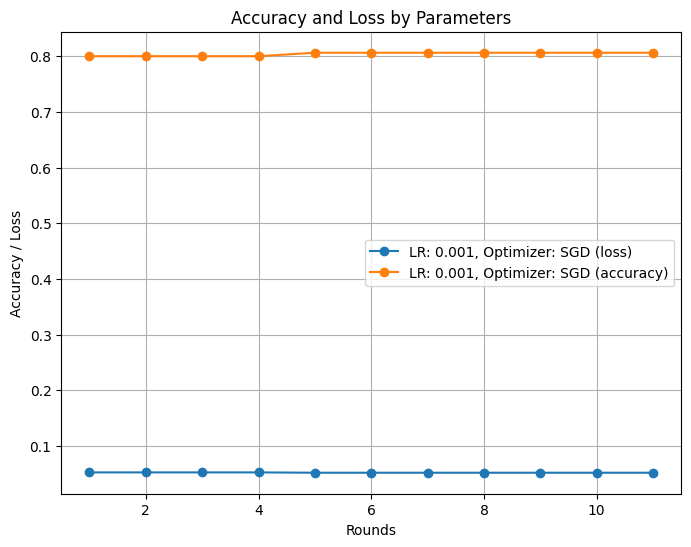

In [73]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [74]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 10, 'FP': 2, 'FN': 59, 'TN': 287}, 'Accuracy': 0.83, 'Sensitivity/Recall': 0.145, 'Specificity': 0.993, 'PPV/Precision': 0.833, 'NPV': 0.829, 'F1-score': 0.247, 'False positive rate': 0.007, 'True positive rate': 0.145}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 8, 'FP': 4, 'FN': 64, 'TN': 282}, 'Accuracy': 0.81, 'Sensitivity/Recall': 0.111, 'Specificity': 0.986, 'PPV/Precision': 0.667, 'NPV': 0.815, 'F1-score': 0.19, 'False positive rate': 0.014, 'True positive rate': 0.111}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 8, 'FP': 1, 'FN': 53, 'TN': 297}, 'Accuracy': 0.85, 'Sensitivity/Recall': 0.131, 'Specificity': 0.997, 'PPV/Precision': 0.889, 'NPV': 0.849, 'F1-score': 0.229, 'False positive rate': 0.003, 'True positive rate': 0.131}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion matrix': {

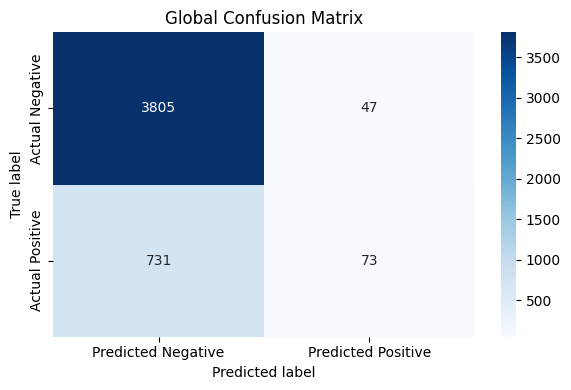

In [75]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the first fl_pipeline")

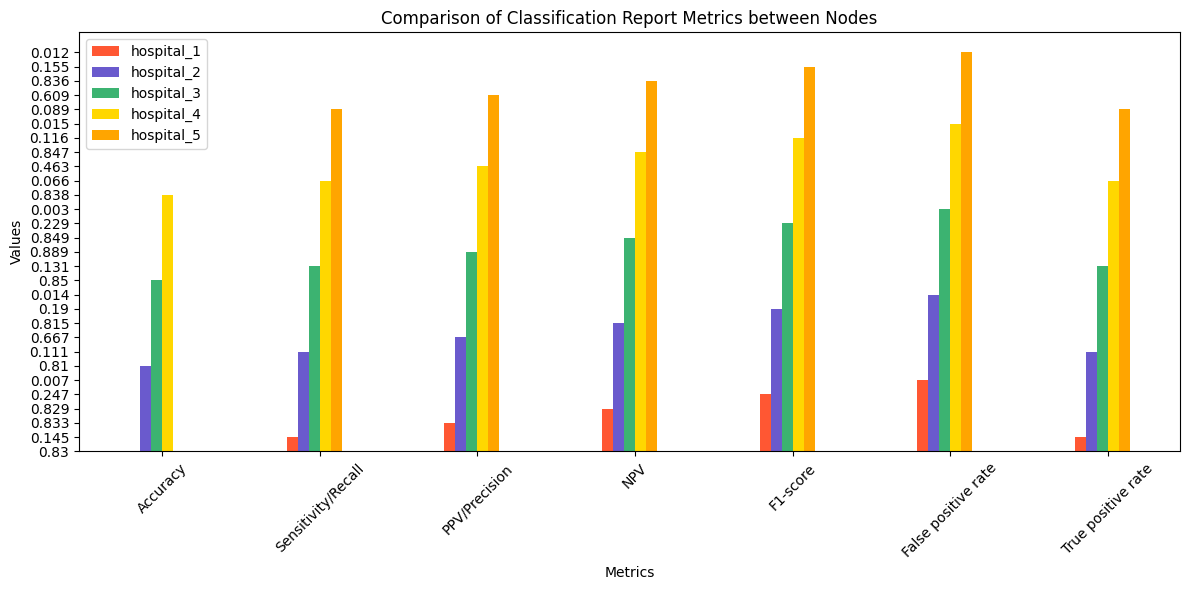

In [76]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")